In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from IPython.display import Image
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from surprise import SVD, Dataset, Reader
from surprise.model_selection import PredefinedKFold
from collections import defaultdict
from surprise.accuracy import rmse
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline 
sns.set(style="ticks")

# [Введение в рекомендательные системы](https://ru.wikipedia.org/wiki/%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0) с использованием методов машинного обучения

## Набор данных

В качестве набора данных будем использовать набор данных о рекомендациях фильмов - https://www.kaggle.com/rounakbanik/the-movies-dataset

Набор данных содержит много информации мы будем использовать следующие файлы:
- movies_metadata_overview.csv - информация о фильмах, наиболее важные колонки из файла movies_metadata.csv
- ratings_small.csv - рейтинги фильмов
- links_small.csv - вспомогательный файл для связи по индексам

### Чтение данных

In [2]:
df_md_all = pd.read_csv('data/movies_metadata_overview.csv')

In [3]:
df_md_all.head()

,Unnamed: 0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,imdbId
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,114709
1,1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,113497
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,113228
3,3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,114885
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,113041


In [4]:
df_md_all.shape

(9074, 26)

In [5]:
df_rt = pd.read_csv('data/ratings_small.csv')

In [6]:
df_rt.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
df_rt.shape

(100004, 4)

In [8]:
df_links = pd.read_csv('data/links_small.csv')

In [9]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [10]:
df_links.shape

(9125, 3)

In [11]:
# Преобразуем идентификаторы к типу int
links_ids = df_links[df_links['tmdbId'].notnull()]['tmdbId'].astype('int')

In [12]:
# Оставляем только фильмы, которые есть в df_links
df_md = df_md_all[df_md_all['id'].isin(links_ids)]

In [13]:
df_md_all.shape, df_md.shape

((9074, 26), (9072, 26))

#### Выбор идентификаторов для связи таблиц

Нет очевидной связи по идентификаторам между файлами датасета. Эта проблема встречается в датасетах достаточно часто.

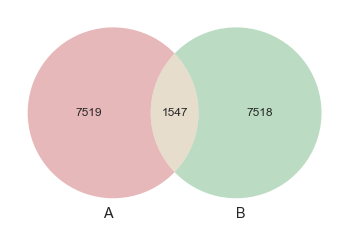

In [14]:
# movieId в таблице рейтингов не соответствует id в основной таблице
venn2([set(df_rt['movieId'].unique()), set(df_md['id'].unique())])

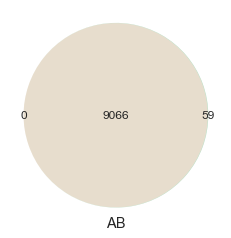

In [15]:
# movieId в таблице рейтингов совпадает с movieId в таблице связей
venn2([set(df_rt['movieId'].unique()), set(df_links['movieId'].unique())])

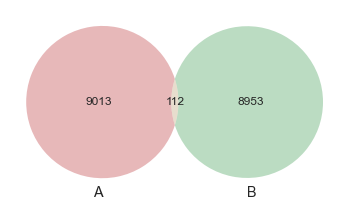

In [16]:
venn2([set(df_links['imdbId'].unique()), set(df_md['id'].unique())])

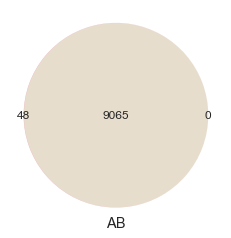

In [17]:
venn2([set(df_links['tmdbId'].unique()), set(df_md['id'].unique())])

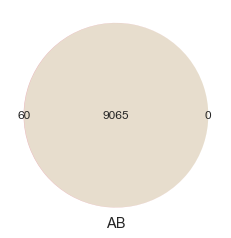

In [18]:
venn2([set(df_links['imdbId'].unique()), set(df_md['imdbId'].unique())])

Для того, чтобы получить название фильма по таблице рейтингов, можно использовать следующие связи:
1. df_rt['movieId'] -> df_links['movieId']
2. одну из следующих связей:
   1. df_links['tmdbId'] -> df_md['id']
   1. df_links['imdbId'] -> df_md['imdbId']

### Векторизация описания фильмов

In [19]:
# У некоторых фильмов отсутствует описание
df_md_with_overview = df_md[df_md['overview'].notnull()]
df_md_with_overview = df_md_with_overview[~df_md_with_overview['overview'].str.isspace()]

In [20]:
imdb = df_md_with_overview['imdbId'].values
imdb[0:5]

array([114709, 113497, 113228, 114885, 113041], dtype=int64)

In [21]:
title = df_md_with_overview['title'].values
title[0:5]

array(['Toy Story', 'Jumanji', 'Grumpier Old Men', 'Waiting to Exhale',
       'Father of the Bride Part II'], dtype=object)

In [22]:
overview = df_md_with_overview['overview'].values
overview[0:5]

array(["Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
       "When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",
       "A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in

In [23]:
%%time
tfidfv = TfidfVectorizer()
overview_matrix = tfidfv.fit_transform(overview)
overview_matrix

Wall time: 998 ms


<9059x29975 sparse matrix of type '<class 'numpy.float64'>'
	with 373942 stored elements in Compressed Sparse Row format>

В результате векторизации только по описанию фильма получилось около 30000 признаков, поэтому в рекомендательных системах часто применяют методы понижения размерности.

## Введение

В соответствии с определением [1] рекомендательная система – 
«это программное средство, предназначенное для выделения объектов предметной области, 
наиболее интересных пользователю». 

В [1] также отмечается, что рекомендательные системы относятся к «информационным фильтрующим системам», 
основной задачей которых является удаление из области видимости пользователя нежелательной, 
нерелевантной или избыточной информации.

В наши дни рекомендательные системы используются повсеместно. 
Это очень востребованная модель, которая не только повышает спрос на товары и услуги, 
но и делает использование информационных ресурсов более удобным для пользователя. 
Наиболее распространенными областями, в которых используются рекомендательные системы, 
являются подбор музыки, фильмов или товаров по предпочтениям пользователей. 
Однако рекомендательные системы могут быть разработаны для любой области. 
Система может рекомендовать новости, аудио, видео, мобильные приложения и многое другое. 
От качества рекомендаций часто зависит, как долго пользователь будет оплачивать подписку на сервис 
или как много товаров купит.

Таким образом, рекомендательные системы выполняют важную задачу, 
концентрируя внимание пользователя на тех объектах предметной области, 
которые входят в область интереса пользователя. 

Возможно создание рекомендательной системы без использования машинного обучения, например, с применением правил или онтологий:
1. Можно ввести жесткие правила (составленные экспертом в предметной области):
  - *ЕСЛИ пользователь покупает бумажную книгу ТО рекомендовать подставку для книг*
  - *ЕСЛИ пользователь покупает электронную книгу ТО рекомендовать ридер для чтения электронных книг*
2. Можно использовать онтологии, которые описывают зависимости в предметной области. Тогда правила пункта 1 не вводятся жестко, а генерируются на основе онтологии.

Преимуществом такого подхода является высокая релевантность рекомендаций, ведь они подобраны экспертами. Недостатками являются:
- слабая зависимость рекомендаций от конкретного пользователя, мы можем знать историю его предыдущих покупок, но она никак не используется;
- могут быть накоплены большие объемы данных о покупках и предпочтениях большого количества пользователей, но между ними не ищется никакой аналогии, и они никак не используются.

Для преодоления указанных недостатков можно использовать методы на основе машинного обучения.

Принципиальным является вопрос о том, каким образом выделить область интереса пользователя (предпочтения пользователя).

Предпочтения пользователя можно выявить и в подходе на основе правил или онтологий, но при этом пользователь должен проходить опрос, в результате которого эксперты должны вручную менять правила или онтологию. В случае использования методов машинного обучения можно отказаться от опроса пользователя и выявлять его интересы на основе накопленных данных.



В рекомендательных системах принята следующая терминология:
- **«объект предметной области»** (item, object) - объект, для которого определяется степень сходства с другими объектами (это может быть не физическое сходство, а сходство, обусловленное потребностями пользователя). На приведенном рисунке item<==>article.
- **«пользователь»** (user) - пользователь рекомендательной системы: 
  1. для которого мы пытаемся сформировать рекомендации (иногда используется термин «текущий пользователь»);
  2. мнения которого сохранены в рекомендательной системе и используются для формирования рекомендаций (иногда используется термин «похожий или схожий пользователь»).
  
В [2] отмечается, что в случае использования методов машинного обучения существуют две основные стратегии создания рекомендательных систем: 
- фильтрация на основе содержания (данный метод также называют «content-based filtering»);
- коллаборативная фильтрация (данный метод также называют «collaborative filtering»);
- а также гибридный подход, использующий обе стратегии.

В случае фильтрации на основе содержания область интереса пользователя определяется объектами предметной области, 
которые создал, выбрал или запросил пользователь 
(тексты запросов пользователя, созданные им документы, комментарии и т.д.). 
Решение задачи фильтрации состоит в том, чтобы выделить в предметной области схожие, 
но еще не известные пользователю объекты. Основной задачей является **нахождение схожих объектов предметной области**.

В случае коллаборативной фильтрации нам доступна информация о предпочтениях большого количества пользователей 
в нашей предметной области. Решение задачи фильтрации состоит в том, 
чтобы найти наиболее похожих (схожих) пользователей и предложить текущему пользователю те объекты предметной области, которые они выбирали. 
Основными задачами являются **нахождение схожих пользователей** и **нахождение схожих объектов предметной области**.


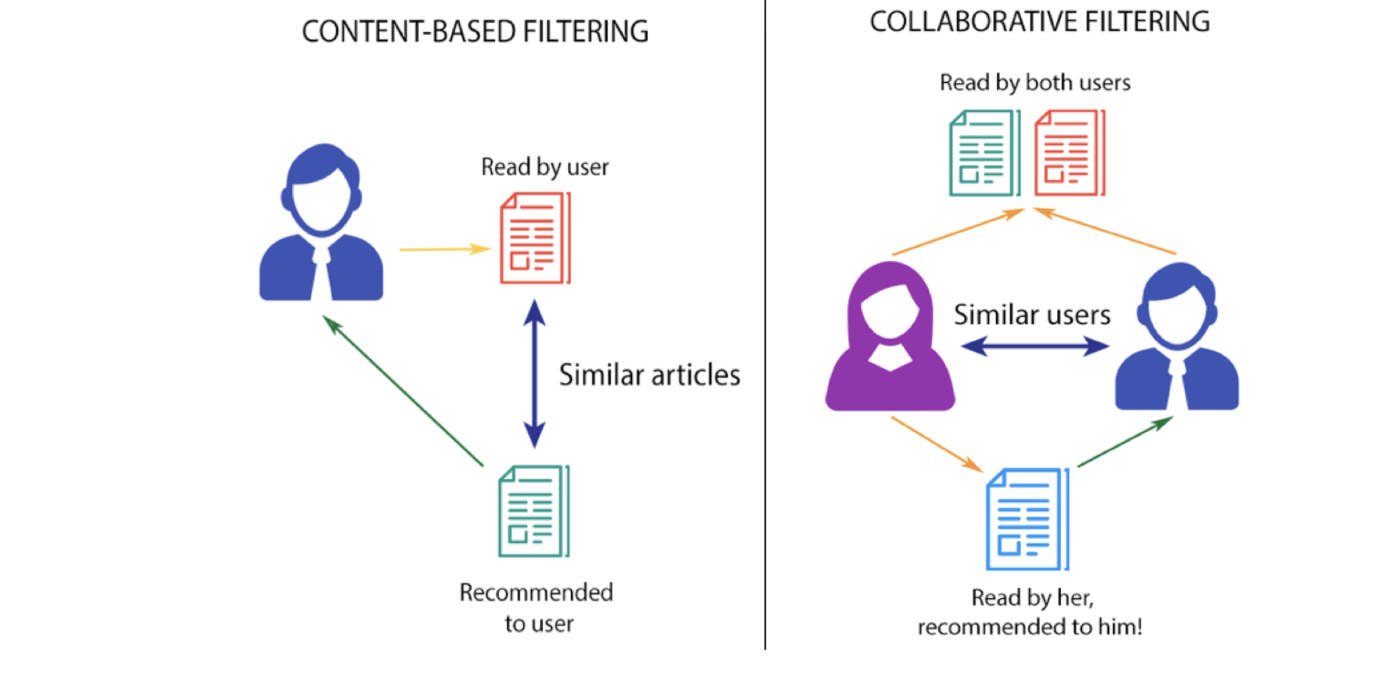

In [66]:
# Источник - https://medium.com/analytics-vidhya/collaborative-based-recommendation-system-using-svd-9adc5b6b3b8
Image('img/rec_types.png', width='80%')

## Используемые программные средства

- [Обзор](https://analyticsindiamag.com/top-open-source-recommender-systems-in-python-for-your-ml-project/) существующих библиотек для создания рекомендательных систем.
- Библиотека [Surprise](http://surpriselib.com/) - специализированная библиотека для рекомендательных систем. Ориентирована на методы коллаборативной фильтрации. С сентября 2019 года только поддерживается, но не развивается.
- Библиотека [Case Recommender](https://github.com/caserec/CaseRecommender) также не развивается.
- Библиотека scikit-learn для базовых функций машинного обучения.

## Фильтрация на основе содержания

Для решения задачи **нахождения схожих объектов предметной области** нам необходимо:
1. Метрическое пространство. То есть пространство, в котором можно определить расстояние между объектами на основе какой-либо метрики.
2. Способ преобразования **«объектов предметной области»** в точки этого пространства. Такое преобразование называют **векторизацией** или **эмбеддингом (embedding)**.

В простейшем случае фильтрация на основе содержания отчасти напоминает метод К ближайших соседей в варианте обучения без учителя и отчасти алгоритмы кластеризации. 

#### 1) Интерпретация с точки зрения метода К ближайших соседей:

В случае Knn обучения с учителем мы заранее задаем гиперпараметр К. 

В данном случае мы сначала ранжируем соседей на основе метрики а затем выбираем К ближайших. Параметр К может задаваться: 
- фиксированно (например, мы всегда рекомендуем К=const наиболее похожих объектов);
- или мы можем отслеживать изменение метрики и прекращать рекомендации при резком увеличении расстояния до следующего соседа. Данный способ отчасти напоминает "правило локтя", которое используется в кластеризации.

#### 2) Интерпретация с точки зрения методов кластеризации:

- Выполняем процедуру кластеризации и рекомендуем объекты того кластера, в который попадает «текущий объект».
- Поскольку в кластере может оказаться много объектов, то из них можно отобрать К=const ближайших.

### Метрики

В качестве метрики наиболее часто используется косинусное сходство между векторами. Для векторов $p$ и $q$ в n-мерном пространстве:

$$ d(p,q)= \frac{\langle p,q \rangle}{||p|| \cdot ||q||} = \frac{\sum\limits_{i=1}^N p_i \cdot q_i }{ \sqrt{\sum\limits_{i=1}^N p_i^2} \cdot \sqrt{\sum\limits_{i=1}^N q_i^2} } $$

В библиотеке scikit-learn для вычисления косинусного сходства  реализована функция [cosine_similarity.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

Также может использоваться Евклидова метрика: 
  $$d(p,q)= \sqrt{ (p_1-q_1)^2 + (p_2-q_2)^2 + \cdots + (p_n-q_n)^2 } = \sqrt{ \sum_{i=1}^{n} (p_i-q_i)^2} $$
или более сложные метрики http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html

В библиотеке Surprise также используются [следующие расстояния.](https://surprise.readthedocs.io/en/stable/similarities.html) К сожалению, они могут быть использованы только как параметры функций для коллаборативной фильтрации и не вызываются напрямую.

### Пример реализации

Реализуем класс для формирования рекомендаций на основе метода ближайших соседей:

In [25]:
class SimpleKNNRecommender:
    
    def __init__(self, X_matrix, X_ids, X_title, X_overview):
        """
        Входные параметры:
        X_matrix - обучающая выборка (матрица объект-признак)
        X_ids - массив идентификаторов объектов
        X_title - массив названий объектов
        X_overview - массив описаний объектов
        """
        #Сохраняем параметры в переменных объекта
        self._X_matrix = X_matrix
        self.df = pd.DataFrame(
            {'id': pd.Series(X_ids, dtype='int'),
            'title': pd.Series(X_title, dtype='str'),
            'overview': pd.Series(X_overview, dtype='str'),
            'dist': pd.Series([], dtype='float')})
            
            
    def recommend_for_single_object(self, K: int, \
                X_matrix_object, cos_flag = True, manh_flag = False):
        """
        Метод формирования рекомендаций для одного объекта.
        Входные параметры:
        K - количество рекомендуемых соседей 
        X_matrix_object - строка матрицы объект-признак, соответствующая объекту
        cos_flag - флаг вычисления косинусного расстояния
        manh_flag - флаг вычисления манхэттэнского расстояния
        Возвращаемое значение: K найденных соседей
        """
        
        scale = 1000000
        # Вычисляем косинусную близость
        if cos_flag:
            dist = cosine_similarity(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=False)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] < scale]
        
        else:
            if manh_flag:
                dist = manhattan_distances(self._X_matrix, X_matrix_object)
            else:
                dist = euclidean_distances(self._X_matrix, X_matrix_object)
            self.df['dist'] = dist * scale
            res = self.df.sort_values(by='dist', ascending=True)
            # Не учитываем рекомендации с единичным расстоянием,
            # так как это искомый объект
            res = res[res['dist'] > 0.0]            
        
        # Оставляем К первых рекомендаций
        res = res.head(K)
        return res


In [26]:
# Тестовый пример - будем искать фильмы, похожие на звездные войны
star_wars_ind = 232
title[star_wars_ind]

'Star Wars'

In [27]:
star_wars_matrix = overview_matrix[star_wars_ind]
star_wars_matrix

<1x29975 sparse matrix of type '<class 'numpy.float64'>'
	with 41 stored elements in Compressed Sparse Row format>

In [28]:
skr1 = SimpleKNNRecommender(overview_matrix, imdb, title, overview)

In [29]:
# 15 фильмов похожих на звездные войны
# в порядке убывания схожести на основе косинусного сходства
rec1 = skr1.recommend_for_single_object(15, star_wars_matrix)
rec1

,id,title,overview,dist
945,80684,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",427802.579392
8728,2488496,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,257752.298232
958,86190,Return of the Jedi,As Rebel leaders map their strategy for an all...,223762.960076
278,111333,The Swan Princess,The beautiful princess Odette is transformed i...,147301.891662
9051,5595168,Kingsglaive: Final Fantasy XV,The magical kingdom of Lucis is home to the wo...,141781.194426
2532,151568,Topsy-Turvy,"After their production ""Princess Ida"" meets wi...",138391.728606
1648,53285,Sleeping Beauty,A beautiful princess born in a faraway kingdom...,132156.169647
413,107144,Hot Shots! Part Deux,Topper Harley is found to be working as an odd...,130543.027769
2883,184894,Shanghai Noon,"Chon Wang, a clumsy imperial guard trails Prin...",129328.976669
5163,73822,The Magic Flute,The Queen of the Night enlists a handsome prin...,123379.516225


In [30]:
# При поиске с помощью Евклидова расстояния получаем такой же результат
rec2 = skr1.recommend_for_single_object(15, star_wars_matrix, cos_flag = False)
rec2

,id,title,overview,dist
945,80684,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...",1.069764e+06
8728,2488496,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,1.218399e+06
958,86190,Return of the Jedi,As Rebel leaders map their strategy for an all...,1.245983e+06
278,111333,The Swan Princess,The beautiful princess Odette is transformed i...,1.305908e+06
9051,5595168,Kingsglaive: Final Fantasy XV,The magical kingdom of Lucis is home to the wo...,1.310129e+06
2532,151568,Topsy-Turvy,"After their production ""Princess Ida"" meets wi...",1.312713e+06
1648,53285,Sleeping Beauty,A beautiful princess born in a faraway kingdom...,1.317455e+06
413,107144,Hot Shots! Part Deux,Topper Harley is found to be working as an odd...,1.318679e+06
2883,184894,Shanghai Noon,"Chon Wang, a clumsy imperial guard trails Prin...",1.319599e+06
5163,73822,The Magic Flute,The Queen of the Night enlists a handsome prin...,1.324100e+06


In [31]:
# Манхэттэнское расстояние дает нерелевантные результаты поиска
rec3 = skr1.recommend_for_single_object(15, star_wars_matrix, 
                                        cos_flag = False, manh_flag = True)
rec3

,id,title,overview,dist
1336,112318,Alien Escape,No overview found.,7.608845e+06
5156,88650,28 Up,No overview found.,7.608845e+06
665,110246,Kaspar Hauser,No overview found.,7.608845e+06
8899,3605164,Requiem For The Big East,Documentary about the Big East.,7.783086e+06
8204,1956594,Paul Williams Still Alive,Documentary about Paul Williams,7.890518e+06
1487,29146,The Life of Emile Zola,Bio epic of the famous writer.,7.900881e+06
7115,243951,Hamlet,"To be or not to be, etc.",7.911869e+06
6940,11439,The Mark of Zorro,The adventures of the masked hero continues.,7.913708e+06
8442,2113683,I Know That Voice,A documentary about voice-over actors.,7.932479e+06
5436,342213,Comandante,Documentary on the director's meeting with Cas...,7.977159e+06


### Выводы
- Фильтрация на основе содержания позволяет получать рекомендации на основе известных объектов предметной области.
- Для фильтрации на основе содержания очень важны и способы векторизации объектов и выбор метрики для вычисления расстояния между объектами.
- В отличие коллаборативной фильтрации, фильтрация на основе содержания не использует данные о предпочтениях других пользователях рекомендательной системы.

## Коллаборативная фильтрация

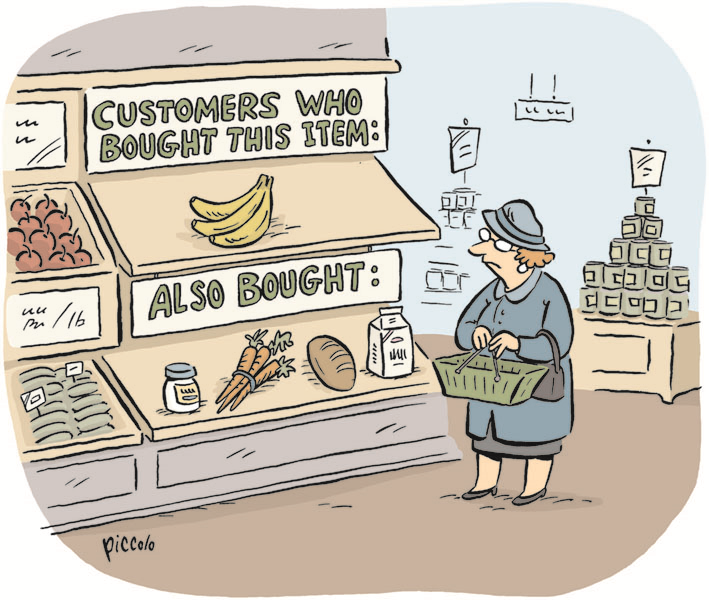

In [67]:
# Источник - https://www.kaggle.com/rounakbanik/movie-recommender-systems
Image('img/also_bought.png', width='50%')

Приведенный на рисунке пример коллаборативной фильтрации **не требует машинного обучения**. Эта задача решается путем запросов к базе данных:
1. На основе корзины текущего пользователя получить список пользователей, которые покупали такие же товары.
2. Для найденных пользователей получить список других товаров и порекомендовать их текущему пользователю.

Но в настоящее время для решения задачи используются методы машинного обучения. Результаты могут быть получены проще, быстрее и т.д.

### Постановка задачи

Основной моделью данных коллаборативной фильтрации является **матрица взаимодействий (interactions matrix)**. Также встречается название **таблица оценок**. Строки матрицы соответствуют пользователям, а столбцы матрицы соответствуют объектам. На пересечении столбца и строки находится оценка объекта пользователем.

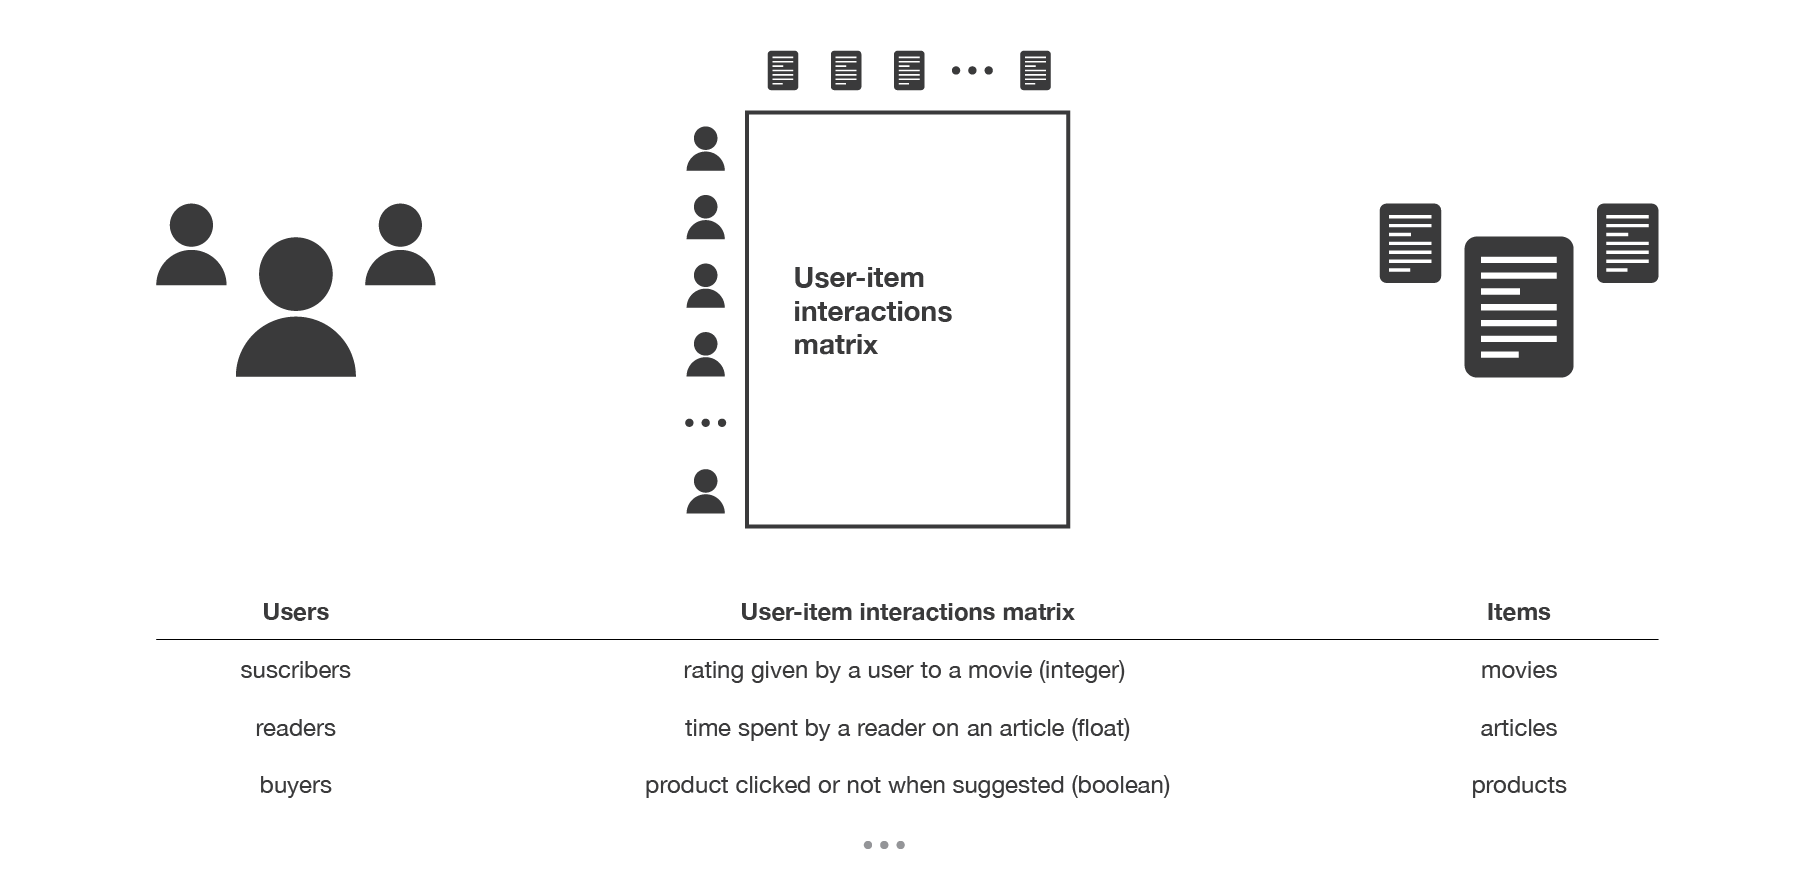

In [65]:
# Источник - https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
Image('img/interactions_matrix.png', width='80%')

### Классификация рекомендательных систем

Методы коллаборативной фильтрации принято подразделять на: 
- методы, основанные на матрице взаимодействий (**memory based**);
- методы, основанные на моделях (**model based**).

С учетом этого, может быть предложена следующая классификация рекомендательных систем: 

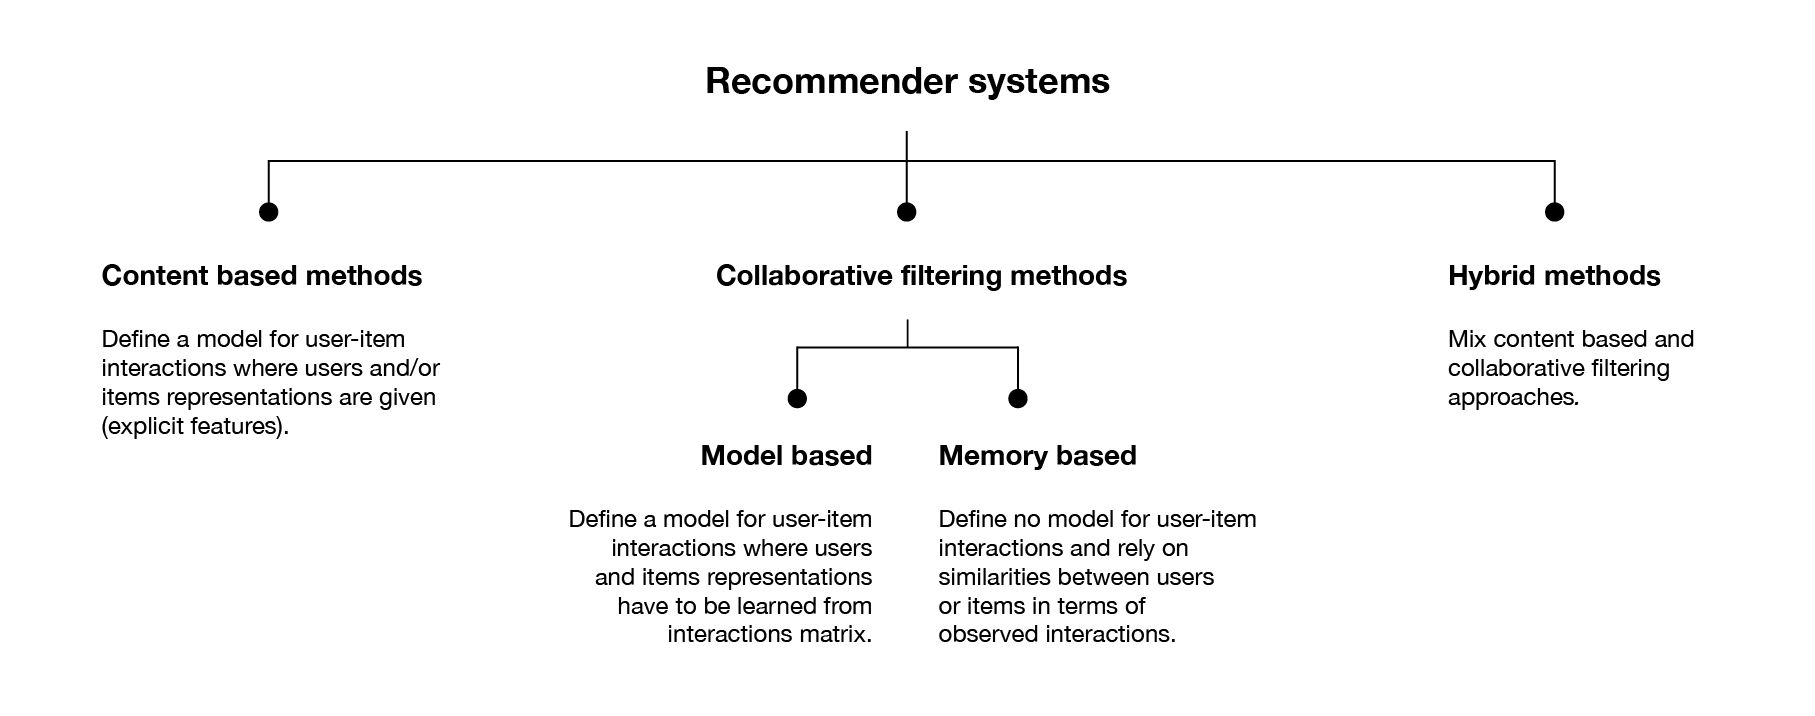

In [34]:
# Источник - https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
Image('img/rec_class.png', width='100%')

### Memory-based методы

В свою очередь, методы, основанные на матрице взаимодействий (**memory based** методы) подразделяют на:
- метод **основанный на пользователях** или **пользователь-пользователь** (**user-based** или **user-user**);
- метод **основанный на объектах** или **объект-объект** (**item-based** или **item-item**).

#### Метод пользователь-пользователь

В случае метода **user-based**:
1. Определяются пользователи, наиболее похожие по оценкам на текущего пользователя (для которого формируется рекомендация). 
1. Для найденных пользователей находятся наиболее позитивно оцененные объекты, которые еще неизвестны текущему пользователю (текущий пользователь еще не оценивал эти объекты).
1. Найденные объекты предлагаются текущему пользователю.

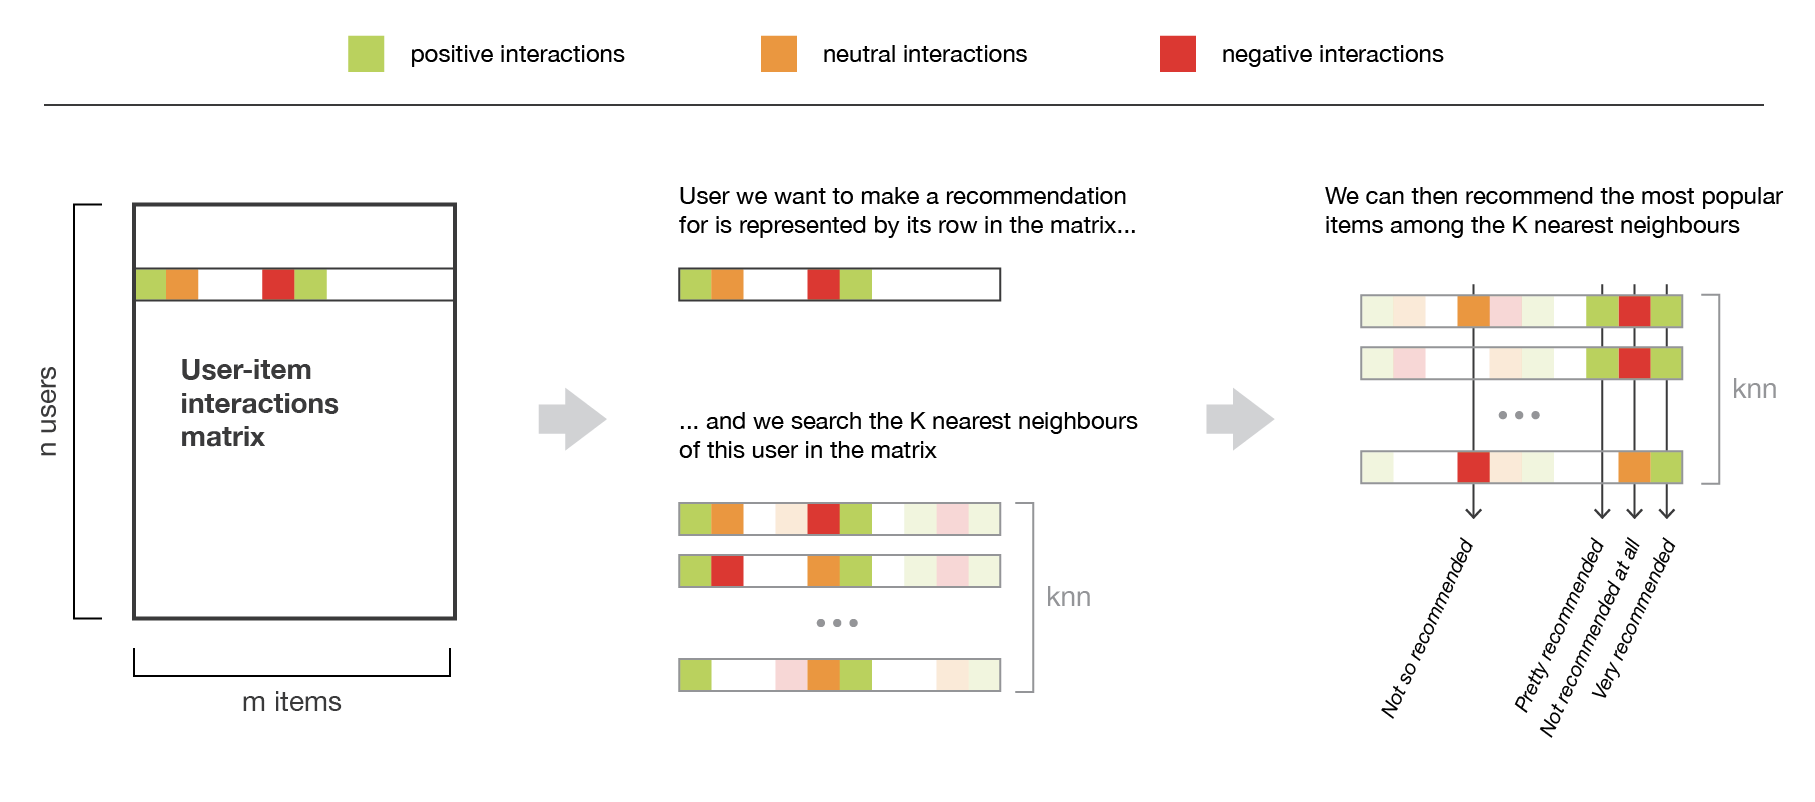

In [35]:
# Источник - https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
Image('img/user_user.png', width='100%')

#### Метод объект-объект

В случае метода **item-based**:
1. Для текущего пользователя определяется текущий объект (объект, который наиболее предпочтителен для формирования рекомендаций).
1. Определяются объекты, наиболее похожие по оценкам на текущий объект, из них может быть выбрано K наиболее похожих.

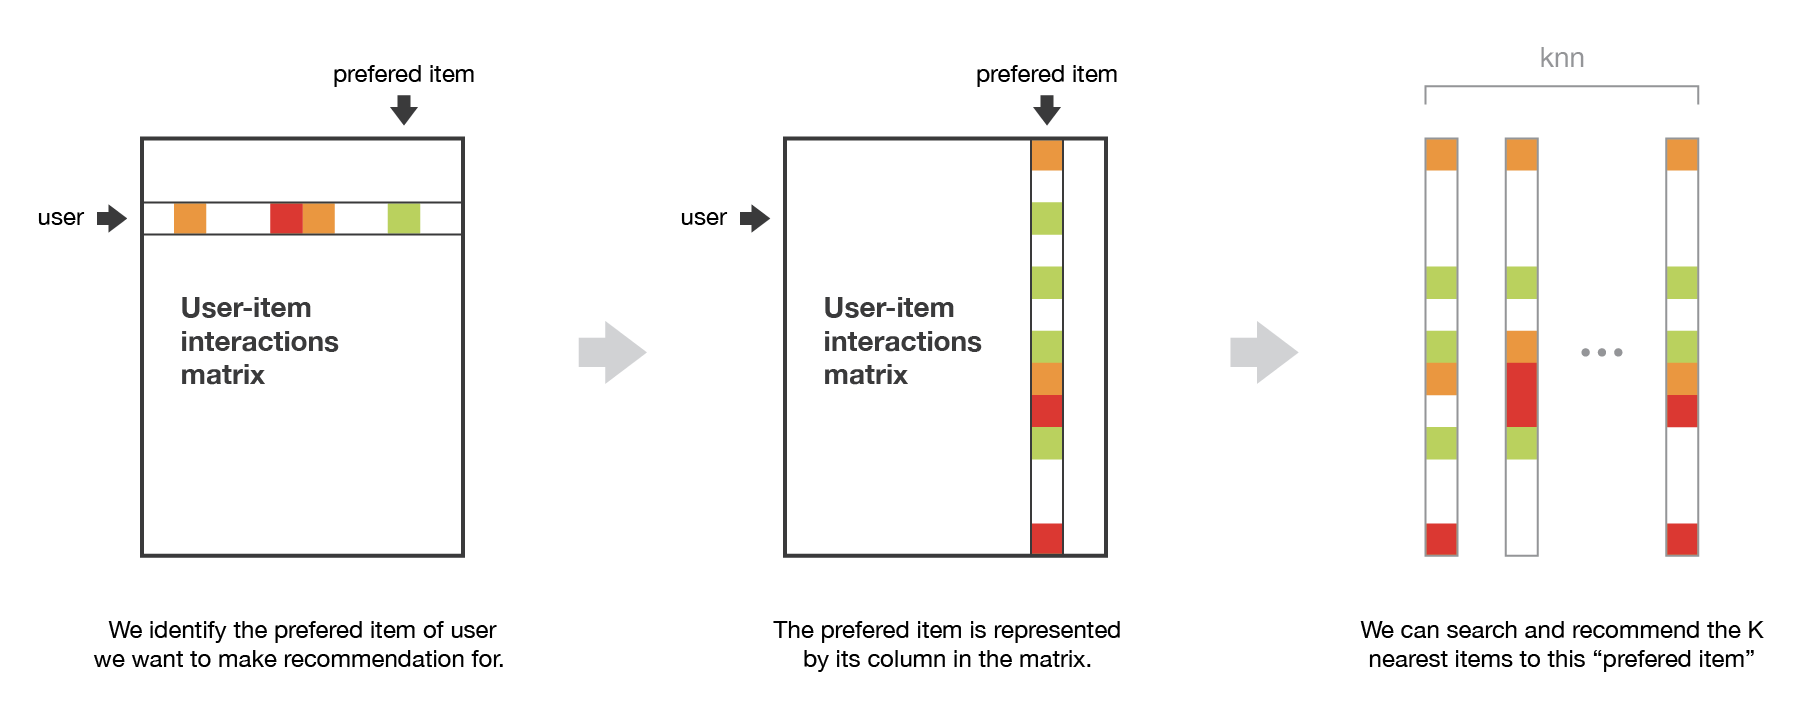

In [36]:
# Источник - https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
Image('img/item_item.png', width='100%')

В библиотеке Surprise используются [следующие подходы на основе метода ближайших соседей.](https://surprise.readthedocs.io/en/stable/knn_inspired.html)

В библиотеке Surprise используются обозначения, принятые в работе [Y. Koren](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf): "We reserve special indexing letters for distinguishing users from items: for users u,v, and for items i,j."

Можно выделить следующие Knn подобные подходы:
- «Наивные» рекомендации. При формировании «наивных» рекомендаций для объекта или пользователя вычисляется средняя оценка.
- Рекомендации с учетом коэффициента схожести. Данный метод отличается от «наивного» тем, что учитываются степени значимости используемых оценок. Вместо средней оценки используется среднее взвешенное по схожести. В библиотеке Surprise реализуется с использованием класса KNNBasic.
- Рекомендации на основе средних оценок и коэффициента схожести. Данный метод построен на основе предыдущего и учитывает средние оценки для пользователя. В библиотеке Surprise реализуется с использованием класса KNNWithMeans.
- Рекомендации с использованием Z-оценки. Метод использует нормализацию на основе Z-оценки для каждого пользователя. В библиотеке Surprise реализуется с использованием класса KNNWithZScore.
- Рекомендации с использованием бейзлайна. Метод похож на метод на основе средних оценок и коэффициента схожести, но вместо средних оценок используются бейзлайн-оценки (которые описаны [в секции 2.1 статьи Y. Koren](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)).


#### Выводы
- Считается что метод user-based дает более персонализированные рекомендации чем item-based.
- Метод item-based считается менее персонализированным, но более надежным.

### Model-based методы

#### Метод на основе сингулярного разложения

В качестве метода, основанного на модели (model based) рассмотрим [метод на основе сингулярного разложения](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%BD%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B7%D0%BB%D0%BE%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5).

В этом случае возможно преобразовать разреженную матрицу взаимодействий в несколько неразреженных матриц и выделить латентные (скрытые) факторы.

Сингулярное разложение с точки зрения рекомендательной системы:

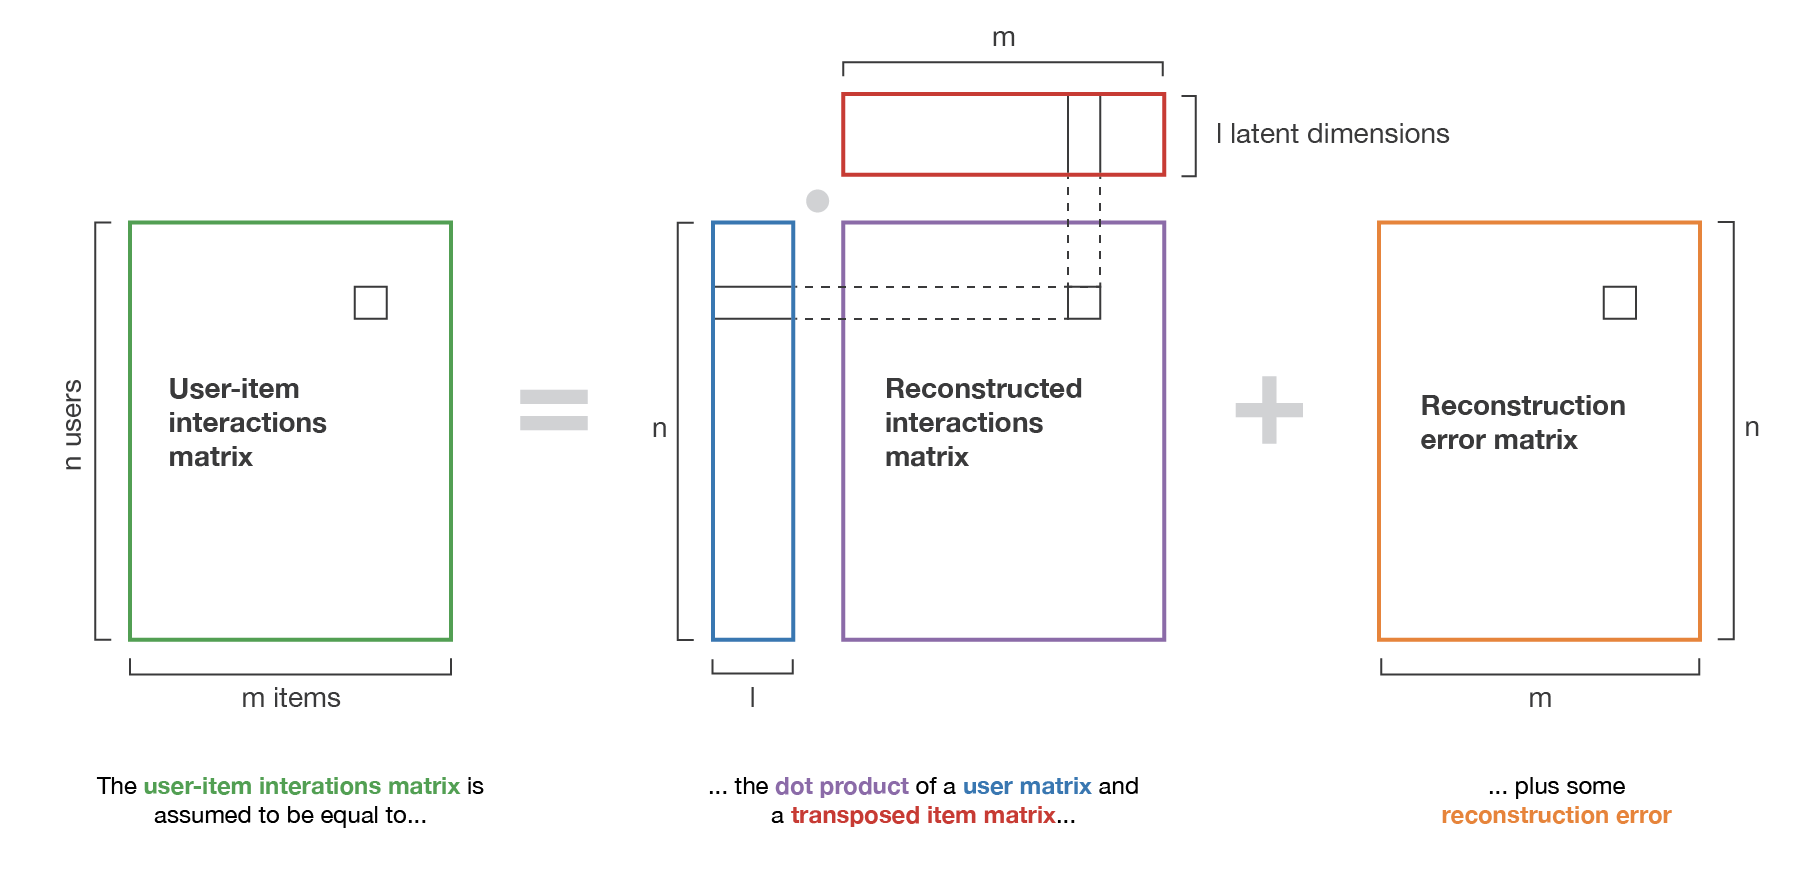

In [37]:
# Источник - https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
Image('img/svd.png', width='100%')

#### Подготовка данных

In [38]:
df_rt.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [39]:
# Количество уникальных пользователей
len(df_rt['userId'].unique())

671

In [40]:
# Количество уникальных фильмов
len(df_rt['movieId'].unique())

9066

In [41]:
# Сформируем матрицу взаимодействий на основе рейтингов
# Используется идея из статьи - https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65
def create_utility_matrix(data):
    itemField = 'movieId'
    userField = 'userId'
    valueField = 'rating'  
    
    userList = data[userField].tolist()
    itemList = data[itemField].tolist()
    valueList = data[valueField].tolist()    
    
    users = list(set(userList))
    items = list(set(itemList))    
    
    users_index = {users[i]: i for i in range(len(users))}    
    pd_dict = {item: [0.0 for i in range(len(users))] for item in items}    
    
    for i in range(0,data.shape[0]):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]    
        pd_dict[item][users_index[user]] = value    
    
    X = pd.DataFrame(pd_dict)
    X.index = users
        
    itemcols = list(X.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
    
    return X, users_index, items_index

In [42]:
%%time
user_item_matrix, users_index, items_index = create_utility_matrix(df_rt)

Wall time: 2.17 s


In [43]:
user_item_matrix

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
670,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Выделение тестовой строки
user_item_matrix__test = user_item_matrix.loc[[671]]
user_item_matrix__test

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
671,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Оставшаяся часть матрицы для обучения
user_item_matrix__train = user_item_matrix.loc[:670]
user_item_matrix__train

,1,2,3,4,5,6,7,8,9,10,...,98230,65465,98243,131013,32728,32735,32743,98279,65514,98296
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Построение модели на основе SVD

Используется идея из [статьи.](https://www.kaggle.com/vincentman0403/recommendation-example-by-svd)

In [46]:
%%time
U, S, VT = np.linalg.svd(user_item_matrix__train.T)
V = VT.T

Wall time: 7.86 s


In [47]:
# Матрица соотношения между пользователями и латентными факторами
U.shape

(9066, 9066)

In [48]:
# Матрица соотношения между объектами и латентными факторами
V.shape

(670, 670)

In [49]:
S.shape

(670,)

In [50]:
Sigma = np.diag(S)
Sigma.shape

(670, 670)

In [51]:
# Диагональная матрица сингулярных значений
Sigma

array([[517.16560996,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , 243.72574288,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 204.30514046, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   3.78050862,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          3.4790538 ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   2.70888263]])

In [52]:
# Используем 3 первых сингулярных значения
r=3
Ur = U[:, :r]
Sr = Sigma[:r, :r]
Vr = V[:, :r]

In [53]:
# Матрица соотношения между новым пользователем и латентными факторами
test_user = np.mat(user_item_matrix__test.values)
test_user.shape, test_user

((1, 9066), matrix([[5., 0., 0., ..., 0., 0., 0.]]))

In [54]:
tmp = test_user * Ur * np.linalg.inv(Sr)
tmp

matrix([[-0.0400839 ,  0.0187124 , -0.00312951]])

In [55]:
test_user_result = np.array([tmp[0,0], tmp[0,1], tmp[0,2]])
test_user_result

array([-0.0400839 ,  0.0187124 , -0.00312951])

In [56]:
# Вычисляем косинусную близость между текущим пользователем 
# и остальными пользователями
cos_sim = cosine_similarity(Vr, test_user_result.reshape(1, -1))
cos_sim[:10]

array([[0.02934196],
       [0.2677369 ],
       [0.8702116 ],
       [0.47661689],
       [0.94749253],
       [0.77708108],
       [0.4362181 ],
       [0.95469573],
       [0.74033119],
       [0.83627691]])

In [57]:
# Преобразуем размерность массива
cos_sim_list = cos_sim.reshape(-1, cos_sim.shape[0])[0]
cos_sim_list[:10]

array([0.02934196, 0.2677369 , 0.8702116 , 0.47661689, 0.94749253,
       0.77708108, 0.4362181 , 0.95469573, 0.74033119, 0.83627691])

In [58]:
# Находим наиболее близкого пользователя
recommended_user_id = np.argsort(-cos_sim_list)[0]
recommended_user_id

595

In [59]:
# Получение названия фильма
movieId_list = list(user_item_matrix.columns)
def film_name_by_movieid(ind):
    try:
        movieId = movieId_list[ind]
        flt_links = df_links[df_links['movieId'] == movieId]
        tmdbId = int(flt_links['tmdbId'].values[0])
        md_links = df_md[df_md['id'] == tmdbId]
        res = md_links['title'].values[0]
        return res
    except:
        return '' 

In [60]:
# Фильмы, которые оценивал текущий пользователь:
i=1
for idx, item in enumerate(np.ndarray.flatten(np.array(test_user))):
    if item > 0:
        film_title = film_name_by_movieid(idx)
        print('{} - {} - {}'.format(idx, film_title, item))
        if i==20:
            break
        else:
            i+=1

0 - Toy Story - 5.0
35 - Dead Man Walking - 4.0
49 - The Usual Suspects - 4.5
219 - Dolores Claiborne - 4.0
249 - Star Wars - 5.0
285 - Pulp Fiction - 4.0
306 - The Shawshank Redemption - 5.0
344 - Forrest Gump - 5.0
345 - Four Weddings and a Funeral - 3.0
413 - City Slickers II: The Legend of Curly's Gold - 2.5
438 - The Fugitive - 4.0
508 - Searching for Bobby Fischer - 4.0
530 - The Nightmare Before Christmas - 5.0
559 - Aladdin - 4.0
560 - Terminator 2: Judgment Day - 5.0
561 - Dances with Wolves - 4.0
576 - Fargo - 4.0
680 - A Close Shave - 4.0
819 - The Wizard of Oz - 4.0
928 - The Sound of Music - 5.0


In [61]:
# Фильмы, которые оценивал наиболее схожий пользователь:
i=1
recommended_user_item_matrix = user_item_matrix.loc[[recommended_user_id+1]]
for idx, item in enumerate(np.ndarray.flatten(np.array(recommended_user_item_matrix))):
    if item > 0:
        film_title = film_name_by_movieid(idx)
        print('{} - {} - {}'.format(idx, film_title, item))
        if i==20:
            break
        else:
            i+=1

0 - Toy Story - 3.5
5 - Heat - 4.0
9 - GoldenEye - 3.5
15 - Casino - 5.0
17 - Four Rooms - 3.5
18 - Ace Ventura: When Nature Calls - 2.5
22 - Assassins - 3.5
24 - Leaving Las Vegas - 4.0
30 - Dangerous Minds - 3.0
31 - Twelve Monkeys - 5.0
35 - Dead Man Walking - 3.5
46 - Se7en - 4.0
49 - The Usual Suspects - 4.5
68 - Friday - 4.0
69 - From Dusk Till Dawn - 4.0
91 - Mary Reilly - 3.0
109 - Braveheart - 4.0
110 - Taxi Driver - 5.0
136 - The Birdcage - 4.0
138 - Bad Boys - 4.5


В реальных системах могут использоваться более сложные варианты SVD-разложения, которые описаны в [статье.](https://habr.com/ru/post/486802/)

Некоторые из них реализованы в библиотеке [Surprise.](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

На практике при поиске вариантов SVD-разложения решается задача оптимизации. 

#### Нейросетевые методы

Позволяют предсказывать рекомендации на основе нейронной сети. Библиотеки и обзорные статьи:

- Библиотека [TensorRec.](https://github.com/jfkirk/tensorrec)
- Исходная статья [Neural Collaborative Filtering.](https://arxiv.org/abs/1708.05031)
- [Using Neural Networks for Your Recommender System.](https://developer.nvidia.com/blog/using-neural-networks-for-your-recommender-system/)
- [Neural Collaborative Filtering.](https://www.width.ai/post/neural-collaborative-filtering) 
- [Deep Neural Network Models.](https://developers.google.com/machine-learning/recommendation/dnn/softmax)

Архитектура нейросетевой рекомендательной системы как правило состоит из слоев трех групп:
1. Embedding-слои, которые формируют векторные представления для описания users и items.
2. Слои, формирующие аналог матрицы взаимодействия, и выполняющие разложение этой матрицы.
3. Многослойный персептрон, также оценивающий взаимодействие между users и items.
4. Слои 2 и 3 работают параллельно. Выходы слоев 2 и 3 подаются на выходной слой, который предсказывает вероятности рекомендаций определенного товара определенному пользователю.

Раздел на [papers with code.](https://paperswithcode.com/task/recommendation-systems)

## Гибридные рекомендательные системы

Понятие гибридных рекомендательных систем рассматривается в [1, 2, 3]. При этом отмечается, что термин «гибридный» во многом является аналогом термина «ансамблевый» по аналогии с ансамблевыми моделями машинного обучения. 

В соответствии с [2, 3] в настоящее время используются следующие варианты Гибридных Рекомендательных Систем (ГРС):

1.	«Взвешенная» ГРС. Используется несколько независимых подходов для формирования рекомендаций. В качестве результата берется взвешенная сумма результатов, полученных с помощью данных подходов. Данный подход отчасти напоминает подход бэггинга, который является одной из разновидностей ансамблевых моделей машинного обучения.

2.	ГРС «с ветвлениями». В этом случае ГРС состоит как минимум из двух фаз. Первая фаза связана с предварительным анализом данных. Во второй фазе выбирается наиболее подходящий алгоритм формирования рекомендаций на основе предварительного анализа. Одной из разновидностей данного подхода является введение в модель обратной связи, рекомендации запоминаются в системе и используются в первой фазе, что влияет на выбор алгоритма во второй фазе.

3.	«Каскадная» ГРС или «конвейер». В этом случае несколько рекомендательных алгоритмов располагают последовательно, каждый следующий алгоритм уточняет результаты предыдущего. Данный подход напоминает подход бустинга, который является одной из разновидностей ансамблевых моделей машинного обучения.

4.	«Многоуровневая» ГРС. В этом случае выход одного рекомендательного алгоритма рассматривается как вход для другого алгоритма (мета-алгоритма). Данный подход напоминает подход стекинга, который является одной из разновидностей ансамблевых моделей машинного обучения.

Таким образом, «классические» подходы к гибридизации рекомендательных систем в большей степени напоминают ансамблевые модели машинного обучения.

Гибридные рекомендательные системы позволяют решать проблему [холодного старта](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems)). 

## Метрики, используемые в рекомендательных системах

Детально рассмотрены в [статье.](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/)

- Матрица ошибок. В контексте рекомендательных систем "предсказанные" объекты интерпретируются как объекты, которые рекомендовала система. А "истинные" объекты - это объекты, которые выбрал пользователь.
- Precision. Из всех рекомендованных объектов, какую долю выбрал пользователь.
- Recall. Из всех объектов, которые выбрал пользователь, какая доля была рекомендована.
- Если рейтинги являются действительными числами, то наиболее часто применяется метрика RMSE (Root Mean Squared Error):

$$RMSE(y,\hat{y}) = \sqrt{MSE(y,\hat{y})} = \sqrt{ \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 }$$

где: $y$ - истинное значение рейтинга по результатам предсказаний пользователей; $\hat{y}$ - рейтинг, предсказанный рекомендательной системой; $N$ - размер выборки.

**Более сложные метрики, которые учитывают не только набор рекомендованных объектов, но и то, в каком порядке были рекомендованы объекты:**

- [Mean reciprocal rank](https://ru.wikipedia.org/wiki/%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D1%8B%D0%B9_%D1%80%D0%B0%D0%BD%D0%B3)

- [MAP@k (Mean Average Precision at cutoff k)](http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html)

- [NDCG (Normalized Discounted Cumulative Gain)](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)

# Источники

## Книги
1. Ricci F., Rokach L., Shapira B. Recommender Systems Handbook (2nd. ed.). Springer, 2015.
2. Aggarwal C.C. Recommender Systems: The Textbook. Springer, 2016.
3. Lampropoulos, A.S., Tsihrintzis G.A. Machine Learning Paradigms: Applications in Recommender Systems. Intelligent Systems Reference Library, vol. 92. Springer, 2015.


## Статьи
- [Анатомия рекомендательных систем. Часть первая](https://habr.com/ru/company/lanit/blog/420499/)
- [Анатомия рекомендательных систем. Часть вторая](https://habr.com/ru/company/lanit/blog/421401/)
- [Как работают рекомендательные системы. Лекция в Яндексе](https://habr.com/ru/company/yandex/blog/241455/)
- [Как работают рекомендательные системы](https://neurohive.io/ru/osnovy-data-science/rekomendatelnye-sistemy-modeli-i-ocenka/)
- [Baptiste Rocca. Introduction to recommender systems](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)
- [Movies Recommender System](https://www.kaggle.com/rounakbanik/movie-recommender-systems)
- [Yehuda Koren. Factor in the Neighbors: Scalable andAccurate Collaborative Filtering](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)
- [Comprehensive Guide to build a Recommendation Engine from scratch (in Python)](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/)
- [Статья о факторизации матриц](https://habr.com/ru/post/486802/)